In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from scipy import stats
import pickle

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import FunctionTransformer

In [2]:
df = pd.read_csv('data_science_salaries_clean.csv',index_col=0)
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_clean,outsourced,employee_residence_gdp,company_location_gdp,employee_latitude,employee_longitude,company_latitude,company_longitude
0,2024,SE,FT,Data Architect,363000,US,0,US,M,Data Architect,False,63700,63700,37.090240,-95.712891,37.090240,-95.712891
1,2024,SE,FT,Data Architect,139800,US,0,US,M,Data Architect,False,63700,63700,37.090240,-95.712891,37.090240,-95.712891
2,2024,MI,FT,Data Scientist,109000,US,100,US,M,Data Science,False,63700,63700,37.090240,-95.712891,37.090240,-95.712891
3,2024,MI,FT,Data Scientist,93000,US,100,US,M,Data Science,False,63700,63700,37.090240,-95.712891,37.090240,-95.712891
4,2024,MI,FT,Research Engineer,38888,PT,0,PT,M,Research Engineer,False,33700,33700,39.399872,-8.224454,39.399872,-8.224454


In [3]:
df.info() # Double checking that columns are still in the correct format

<class 'pandas.core.frame.DataFrame'>
Index: 7974 entries, 0 to 12974
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   work_year               7974 non-null   int64  
 1   experience_level        7974 non-null   object 
 2   employment_type         7974 non-null   object 
 3   job_title               7974 non-null   object 
 4   salary_in_usd           7974 non-null   int64  
 5   employee_residence      7974 non-null   object 
 6   remote_ratio            7974 non-null   int64  
 7   company_location        7974 non-null   object 
 8   company_size            7974 non-null   object 
 9   job_title_clean         7974 non-null   object 
 10  outsourced              7974 non-null   bool   
 11  employee_residence_gdp  7974 non-null   int64  
 12  company_location_gdp    7974 non-null   int64  
 13  employee_latitude       7974 non-null   float64
 14  employee_longitude      7974 non-null   floa

In [4]:
#reimporting vocabulary and creating a vocabulary dictionary with index for countvectorizer
with open('vocabulary.json') as json_file:
    data = json.load(json_file)
    
vocabulary = {}

for idx,word in enumerate(data):
    vocabulary[word] = idx
    
print(vocabulary)

{'AI': 0, 'AWS': 1, 'Admin': 2, 'Analytics': 3, 'Applied': 4, 'Architect': 5, 'Associate': 6, 'Autonomous': 7, 'Azure': 8, 'BI': 9, 'Bear': 10, 'Big': 11, 'Business': 12, 'CRM': 13, 'Chain': 14, 'Clinical': 15, 'Cloud': 16, 'Commercial': 17, 'Compliance': 18, 'Computer': 19, 'Consultant': 20, 'Customer': 21, 'Data': 22, 'DataOps': 23, 'Database': 24, 'Decision': 25, 'Deep': 26, 'DevOps': 27, 'Developer': 28, 'Digital': 29, 'Director': 30, 'ETL': 31, 'Engineer': 32, 'Enterprise': 33, 'Entry': 34, 'Executive': 35, 'Expert': 36, 'Finance': 37, 'Fraud': 38, 'Game': 39, 'Generative': 40, 'Geophysicist': 41, 'Google': 42, 'Graduate': 43, 'Growth': 44, 'HR': 45, 'Head': 46, 'Healthcare': 47, 'IQ': 48, 'IT': 49, 'Imaging': 50, 'Infrastructure': 51, 'Insight': 52, 'Integration': 53, 'Intern': 54, 'Lead': 55, 'Learning': 56, 'Level': 57, 'Logistics': 58, 'ML': 59, 'MLOps': 60, 'Machine': 61, 'Management': 62, 'Manager': 63, 'Managing': 64, 'Marketing': 65, 'Master': 66, 'Modeller': 67, 'NLP': 68

## Strategy for each column
1. `job_title` - Drop column
2. `experience_level` - ordinal encoder with specified ordering
3. `employment_type` - one hot encoding
4. `work_models` - one hot encoding
5. `work_year` - calculate years since reference and drop original column (to allow for forecasting)
6. `employee_residence` - drop column
7. `salary_in_usd` - target variable
8. `company_location` - drop column
9. `company_size` - ordinal encoding with specified orderin
10. `job_title_clean` - vectorizer using known vocabulary
11. `outsourced` - convert to integer
12. `employee_residence_gdp` - scale
13. `company_location_gdp` - scale
14. `employee_latitude` - convert to cartesian, drop original column and scale
15. `employee_longitude` - convert to cartesian, drop original column and scale
16. `company_latitude` - convert to cartesian, drop original column and scale
17. `company_longitude` - convert to cartesian, drop original column and scale

In [5]:
#Create cartesian coordinates for locations rather than latitude and longitude, drop columns and train test split
def xy(df): 
   
    df['employee_x'] = np.cos(df['employee_latitude']) * np.cos(df['employee_longitude'])
    df['employee_y'] = np.cos(df['employee_latitude']) * np.sin(df['employee_longitude'])
    df['employee_z'] = np.sin(df['employee_latitude'])
    
    df['company_x'] = np.cos(df['company_latitude']) * np.cos(df['company_longitude'])
    df['company_y'] = np.cos(df['company_latitude']) * np.sin(df['company_longitude'])
    df['company_z'] = np.sin(df['company_latitude'])
    
    df['years_since_ref'] = df['work_year'] - 2020 #2020 is just a reference year
    
    drop_cols = ['salary_in_usd','job_title','employee_residence','company_location',
                'employee_latitude','employee_longitude','company_latitude','company_longitude','work_year']
    
    df['outsourced'] = df['outsourced'].astype('int')
    df['remote_ratio'] = df['remote_ratio']/100 # to normalize between 0 and 1
    
    y = np.log10(df['salary_in_usd']) #this is important to eliminate negative values
    X = df.drop(drop_cols,axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = xy(df)
X_train.head()

,experience_level,employment_type,remote_ratio,company_size,job_title_clean,outsourced,employee_residence_gdp,company_location_gdp,employee_x,employee_y,employee_z,company_x,company_y,company_z,years_since_ref
348,SE,FT,1.0,M,Data Engineer,0,63700,63700,0.086531,-0.815717,-0.571942,0.086531,-0.815717,-0.571942,4
2386,SE,FT,0.0,M,ML Engineer,0,63700,63700,0.086531,-0.815717,-0.571942,0.086531,-0.815717,-0.571942,4
3284,SE,FT,0.0,M,AI Engineer,0,63700,63700,0.086531,-0.815717,-0.571942,0.086531,-0.815717,-0.571942,3
7695,SE,FT,1.0,M,Applied Science,0,63700,63700,0.086531,-0.815717,-0.571942,0.086531,-0.815717,-0.571942,3
302,EN,FT,0.0,M,Data Science,0,63700,63700,0.086531,-0.815717,-0.571942,0.086531,-0.815717,-0.571942,4


In [6]:
def metrics_output(expected,predicted):
    avg = np.repeat(np.median(expected),len(predicted))
    
    mse_baseline = mean_squared_error(expected,avg)
    mse = mean_squared_error(expected, predicted)
    
    mae_baseline = mean_absolute_error(expected,avg)
    mae = mean_absolute_error(expected, predicted)
    
    mape_baseline = mean_absolute_percentage_error(expected,avg)
    mape = mean_absolute_percentage_error(expected, predicted)
    
    print('Mean Square Error (MSE): {} (baseline: {})'.format(mse,mse_baseline))
    print('Mean Absolute Error (MAE): {} (baseline: {})'.format(mae,mae_baseline))
    print('Mean Absolute Percentage Error (MAE): {} (baseline: {})'.format(mape,mape_baseline))

In [7]:
class ModifiedSimpleImputer(SimpleImputer):
    def transform(self, X):
        return super().transform(X).flatten()

In [8]:
numeric_cols = ['employee_residence_gdp','company_location_gdp',
                'employee_x','employee_y','employee_z',
                'company_x','company_y','company_z',
                'years_since_ref']

categoric_cols = ['employment_type','company_size']

experience_col = ['experience_level']

title_col = ['job_title_clean']

remainder_cols = ['outsourced','remote_ratio']

numeric_transformer = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),
                                ('scaler',StandardScaler())])

experience_transformer = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),
                                   ('encoder',OrdinalEncoder(categories=[['EN','MI','SE','EX']])),
                                   ('scaler',MinMaxScaler())])

categoric_transformer = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),
                                  ('onehot',OneHotEncoder(sparse_output=False))])

title_transformer = Pipeline([('imputer',ModifiedSimpleImputer(strategy='most_frequent')),
                              ('vectorizer',CountVectorizer(vocabulary=vocabulary,lowercase=False))])

preprocessor = ColumnTransformer(transformers=[('numeric',numeric_transformer,numeric_cols),
                                               ('categoric',categoric_transformer,categoric_cols),
                                               ('experience',experience_transformer,experience_col),
                                               ('title',title_transformer,title_col),
                                               ('minmaxcols',SimpleImputer(strategy='most_frequent'),remainder_cols)
                                              ]
                                )

models = [('Quantile Regressor',QuantileRegressor(quantile=0.5,alpha=0,solver='highs-ds')),
          ('Gradient Boost Regressor',GradientBoostingRegressor(loss='quantile',alpha=0.5, random_state=42))]
          
for model in models:
    pipe = Pipeline(steps=[('preprocessor',preprocessor),model])
    
    start = time.time()

    pipe.fit(X_train, y_train)
    cv_score = cross_val_score(pipe, X_train, y_train, cv=5)
    y_pred = pipe.predict(X_train)
    print('{}'.format(model[0]))
    stop = time.time()
    print(f"Training time: {stop - start}s\n")
    print('Training Error Metrics')
    print('Cross Val Train Score: ({} avg) {} '.format(np.average(cv_score),cv_score))
    metrics_output(y_train,pipe.predict(X_train))
    print('\n')
    print('Test Error Metrics')
    print('Score: {}'.format(pipe.score(X_test,y_test)))
    metrics_output(y_test,pipe.predict(X_test))
    print('____')

Quantile Regressor
Training time: 9.715472221374512s

Training Error Metrics
Cross Val Train Score: (0.448098375632605 avg) [0.40822052 0.39162488 0.49038507 0.47670018 0.47356123] 
Mean Square Error (MSE): 0.028065935313151578 (baseline: 0.05448425415334539)
Mean Absolute Error (MAE): 0.12918735612885895 (baseline: 0.17791701235376678)
Mean Absolute Percentage Error (MAE): 0.02549375567709587 (baseline: 0.035614523983478245)


Test Error Metrics
Score: 0.43204649186141675
Mean Square Error (MSE): 0.029226431470508882 (baseline: 0.05226904137380504)
Mean Absolute Error (MAE): 0.1332035965528772 (baseline: 0.17425119440439155)
Mean Absolute Percentage Error (MAE): 0.026196490787269038 (baseline: 0.034788274740179585)
____
Gradient Boost Regressor
Training time: 5.028109550476074s

Training Error Metrics
Cross Val Train Score: (0.4811196171418336 avg) [0.43691661 0.43396925 0.51904645 0.50353649 0.51212929] 
Mean Square Error (MSE): 0.025661509573379364 (baseline: 0.05448425415334539)
Me

The gradient boost regressor is effective here. Increasing the regularization term alpha in the quantile regression model is not helpful as it causes the MSE and MAE to shoot up.

I did some initial tests with Lasso regression but increasing alpha above 0 tanks the model and the same is the case for the quantile regressor so setting the alpha to 0 is the most effective.

The gradient boost regressor is more consistent however, produces a higher score and lower MSE and MAE metrics. Note the score, MSE and MAE metrics are consistent between the training set and the test set and the Cross Val scores have a low variance and are consistent with the test score. This suggests high stability and is much better than the naive estimate of the median (baseline for MSE/MAE and 0 for the Score).

In [9]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employee_residence_gdp',
                                                   'company_location_gdp',
                                                   'employee_x', 'employee_y',
                                                   'employee_z', 'company_x',
                                                   'company_y', 'company_z',
                                                   'years_since_ref']),
                                                 ('categoric',
                                                  Pipeline(steps=[('im...
                                                                                               'Computer': 19,
                                                                                               'Consultant': 20,
                                                                                               'Customer': 21,
                                                                                               'Data': 22,
                                                                                               'DataOps': 23,
                                                                                               'Database': 24,
                                                                                               'Decision': 25,
                                                                                               'Deep': 26,
                                                                                               'DevOps': 27,
                                                                                               'Developer': 28,
                                                                                               'Digital': 29, ...}))]),
                                                  ['job_title_clean']),
                                                 ('minmaxcols',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['outsourced',
                                                   'remote_ratio'])])),
                ('Gradient Boost Regressor',
                 GradientBoostingRegressor(alpha=0.5, loss='quantile',
                                           random_state=42))])

In [10]:
learning_rate_list = [0.05,0.075,0.1,0.2,0.3,0.4,0.5]
estimator_list = list(range(50,160,10))

parameters = {'learning_rate': learning_rate_list,'n_estimators':estimator_list}

pipe = Pipeline(steps=[('preprocessor',preprocessor),
                       ('model',GridSearchCV(GradientBoostingRegressor(loss='quantile',
                                                                       alpha=0.5,
                                                                       random_state=42),
                                             param_grid=parameters))])
pipe.fit(X_train,y_train)
#pipe['model'].cv_results_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employee_residence_gdp',
                                                   'company_location_gdp',
                                                   'employee_x', 'employee_y',
                                                   'employee_z', 'company_x',
                                                   'company_y', 'company_z',
                                                   'years_since_ref']),
                                                 ('categoric',
                                                  Pipeline(steps=[('im...
                                                                                               'Digital': 29, ...}))]),
                                                  ['job_title_clean']),
                                                 ('minmaxcols',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['outsourced',
                                                   'remote_ratio'])])),
                ('model',
                 GridSearchCV(estimator=GradientBoostingRegressor(alpha=0.5,
                                                                  loss='quantile',
                                                                  random_state=42),
                              param_grid={'learning_rate': [0.05, 0.075, 0.1,
                                                            0.2, 0.3, 0.4,
                                                            0.5],
                                          'n_estimators': [50, 60, 70, 80, 90,
                                                           100, 110, 120, 130,
                                                           140, 150]}))])

In [11]:
pipe['model'].cv_results_

{'mean_fit_time': array([0.41323881, 0.47984409, 0.54871397, 0.63280287, 0.69179778,
        0.7639369 , 0.82987957, 0.90139899, 0.96586056, 1.02334266,
        1.13217731, 0.38764467, 0.47704692, 0.5277411 , 0.5945888 ,
        0.67092423, 0.73099422, 0.80665345, 0.86335549, 0.93536015,
        0.97395816, 1.03100209, 0.37388759, 0.44315219, 0.51786108,
        0.5755538 , 0.63975778, 0.70028062, 0.77450891, 0.83407011,
        0.89162073, 0.95399709, 1.0136292 , 0.3549017 , 0.43690982,
        0.47931094, 0.5567203 , 0.60400748, 0.70582919, 0.73158107,
        0.78970795, 0.84843249, 0.90698657, 0.96350574, 0.34027433,
        0.39044757, 0.45416451, 0.52032018, 0.57908106, 0.63422189,
        0.70653734, 0.79012332, 0.81473455, 0.87438869, 0.93442602,
        0.33465657, 0.39269075, 0.45348663, 0.50372162, 0.56713481,
        0.63104358, 0.69671564, 0.74842868, 0.82656784, 0.87540946,
        0.94055128, 0.32990084, 0.39149346, 0.46128464, 0.52202716,
        0.57208076, 0.6303432 ,

In [12]:
cross_val_rank = pd.DataFrame(np.reshape(pipe['model'].cv_results_['rank_test_score'],[len(learning_rate_list),len(estimator_list)]))
cross_val_rank.columns = estimator_list
cross_val_rank.index = learning_rate_list
cross_val_rank.index.name = 'learning rate'
cross_val_rank.columns.name = 'n_estimators'
cross_val_rank

n_estimators,50,60,70,80,90,100,110,120,130,140,150
learning rate,,,,,,,,,,,
0.050,77,76,75,73,72,70,68,56,54,51,50
0.075,74,71,58,52,45,35,32,30,28,25,19
0.100,61,53,49,36,33,31,27,23,15,12,13
0.200,34,29,26,22,20,16,14,18,17,21,24
0.300,11,10,1,5,2,3,4,6,7,8,9
0.400,55,57,59,60,63,62,64,66,69,67,65
0.500,42,39,41,44,46,47,48,43,40,37,38


In [13]:
cross_val_results = pd.DataFrame(np.reshape(pipe['model'].cv_results_['mean_test_score'],[len(learning_rate_list),len(estimator_list)]))
cross_val_results.columns = estimator_list
cross_val_results.index = learning_rate_list

cross_val_results.index.name = 'learning rate'
cross_val_results.columns.name = 'n_estimators'
cross_val_results

n_estimators,50,60,70,80,90,100,110,120,130,140,150
learning rate,,,,,,,,,,,
0.050,0.451592,0.461903,0.467510,0.471164,0.473333,0.474455,0.475333,0.476569,0.477443,0.478134,0.478732
0.075,0.469592,0.474300,0.476351,0.478032,0.479454,0.480388,0.480999,0.481278,0.481976,0.482979,0.483439
0.100,0.475514,0.477478,0.479010,0.479954,0.480824,0.481120,0.482137,0.483075,0.483515,0.483919,0.483686
0.200,0.480723,0.481974,0.482795,0.483095,0.483156,0.483497,0.483561,0.483459,0.483465,0.483120,0.483052
0.300,0.489076,0.489138,0.489619,0.489443,0.489563,0.489549,0.489520,0.489328,0.489231,0.489219,0.489196
0.400,0.477096,0.476455,0.475905,0.475536,0.475479,0.475498,0.475406,0.475354,0.475333,0.475353,0.475377
0.500,0.479619,0.479786,0.479699,0.479545,0.479193,0.479090,0.479055,0.479592,0.479708,0.479802,0.479796


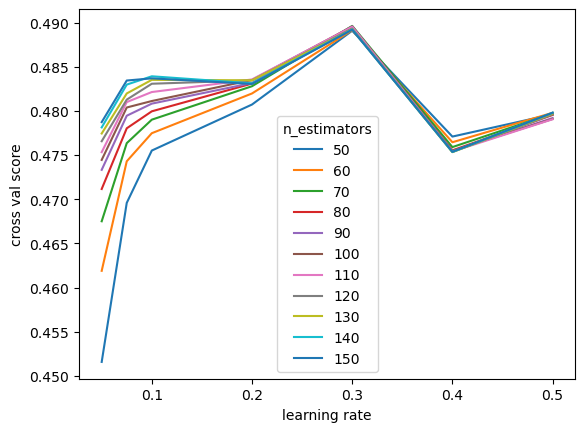

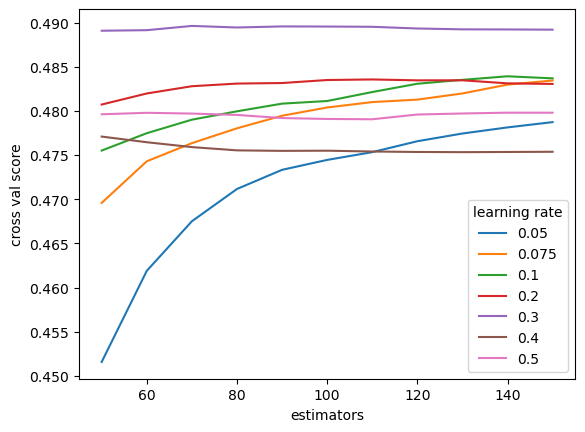

In [14]:
cross_val_results.plot()
plt.xlabel('learning rate')
plt.ylabel('cross val score')
plt.show()

np.transpose(cross_val_results).plot()
plt.xlabel('estimators')
plt.ylabel('cross val score')
plt.show()

In [15]:
for i,y_val in enumerate([10**y_train,y_train]):
    
    pipe_median = Pipeline(steps=[('preprocessor',preprocessor),('model',GradientBoostingRegressor(loss='quantile',alpha=0.5, random_state=42,
                                                                                                  learning_rate=0.3,n_estimators=70))])
    pipe_median.fit(X_train,y_val)
    
    y_pred = pipe_median.predict(X_train)
    y_pred_test = pipe_median.predict(X_test)
    if i==0:
        print('Raw salary prediction')
        
        print('Train score: {}\n'.format(r2_score(y_val,y_pred)))
        print('Error Metrics')
        metrics_output(y_val,y_pred)

        print('____')

        print('Test score: {}\n'.format(r2_score(10**y_test,y_pred_test)))
        print('Error Metrics')
        metrics_output(10**y_test,y_pred_test)
        print('________________\n')
    else:
        print('Log-transformed salary prediction' )    
    
        print('Train score: {}\n'.format(r2_score(10**y_val,10**y_pred)))
        print('Error Metrics')
        metrics_output(10**y_val,10**y_pred)

        print('____')

        print('Test score: {}\n'.format(r2_score(10**y_test,10**y_pred_test)))
        print('Error Metrics')
        metrics_output(10**y_test,10**y_pred_test)

Raw salary prediction
Train score: 0.32946043067143316

Error Metrics
Mean Square Error (MSE): 3557691938.060424 (baseline: 5363177933.601002)
Mean Absolute Error (MAE): 40183.74482032047 (baseline: 54289.70969899665)
Mean Absolute Percentage Error (MAE): 0.3026754329384078 (baseline: 0.5305183329493093)
____
Test score: 0.28063002572108176

Error Metrics
Mean Square Error (MSE): 3767785779.523982 (baseline: 5306279530.29288)
Mean Absolute Error (MAE): 42304.371309395436 (baseline: 53941.72617853561)
Mean Absolute Percentage Error (MAE): 0.315504226208887 (baseline: 0.5122382639371306)
________________

Log-transformed salary prediction
Train score: 0.32937796146484677

Error Metrics
Mean Square Error (MSE): 3558129496.1775455 (baseline: 5363177933.601002)
Mean Absolute Error (MAE): 39990.98094054589 (baseline: 54289.70969899665)
Mean Absolute Percentage Error (MAE): 0.29974535985403616 (baseline: 0.5305183329493093)
____
Test score: 0.2799597989542789

Error Metrics
Mean Square Error 

Above is the comparison of two models and their ability to predict the raw salary. The first model is trained on the raw salary and the second is trained on the log-transformed salary with the reverse transformation performed after fitting. i.e. Does log-transforming provide similar performance when predicting the raw salary compared to if I did not log transform. The test score, MAE and MSE are all comparable between the two models, suggesting that the log transformation does not appreciably affect the ability of the model to predict the raw salary

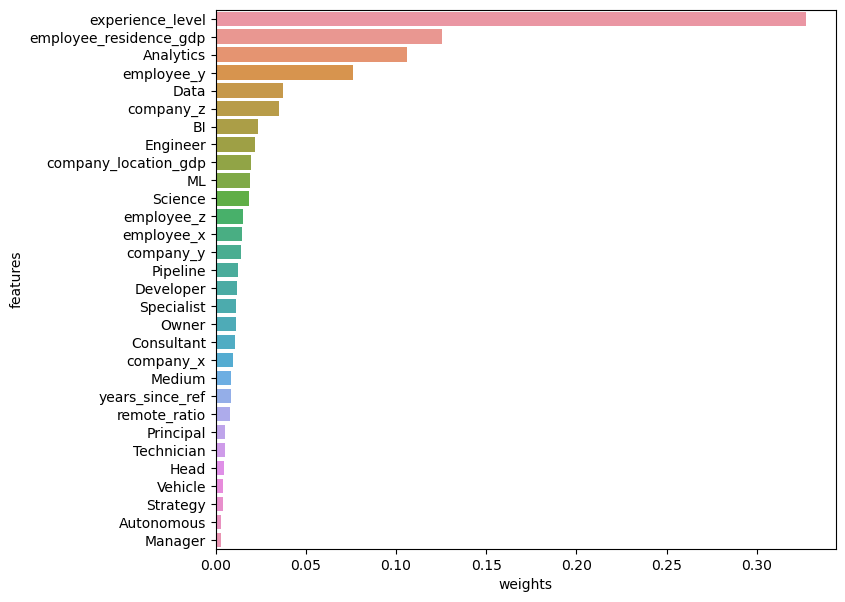

In [16]:
transformed_columns = ['employee_residence_gdp','company_location_gdp',
                       'employee_x','employee_y','employee_z',
                       'company_x','company_y','company_z',
                       'years_since_ref','Contract','Freelance','Full-time','Part-time', 
                       'Large','Medium','Small',
                       'experience_level',
                       'AI', 'AWS', 'Admin', 'Analytics', 'Applied', 'Architect', 'Associate', 'Autonomous',
                       'Azure', 'BI', 'Bear', 'Big', 'Business', 'CRM', 'Chain', 'Clinical', 'Cloud', 'Commercial',
                       'Compliance', 'Computer', 'Consultant', 'Customer', 'Data', 'DataOps', 'Database', 'Decision',
                       'Deep', 'DevOps', 'Developer', 'Digital', 'Director', 'ETL', 'Engineer', 'Enterprise', 'Entry',
                       'Executive', 'Expert', 'Finance', 'Fraud', 'Game', 'Generative', 'Geophysicist', 'Google',
                       'Graduate', 'Growth', 'HR', 'Head', 'Healthcare', 'IQ', 'IT', 'Imaging', 'Infrastructure',
                       'Insight', 'Integration', 'Intern', 'Lead', 'Learning', 'Level', 'Logistics', 'ML', 'MLOps',
                       'Machine', 'Management', 'Manager', 'Managing', 'Marketing', 'Master', 'Modeller', 'NLP',
                       'Operations', 'Operator', 'Owner', 'People', 'Phd', 'Pipeline', 'Portfolio', 'Power',
                       'Practitioner', 'Pricing', 'Principal', 'Process', 'Procurement', 'Product', 'Programmer',
                       'Prompt', 'Python', 'Quality', 'Quantitative', 'Reference', 'Research', 'Robotics', 'Sales', 
                       'Science', 'Software', 'Solution', 'Specialist', 'Sport', 'Staff', 'Strategy', 'Supply',
                       'Tableau', 'Team', 'Tech', 'Technician', 'Vehicle', 'Vision', 'Visualization','outsourced','remote_ratio']

weights = pipe_median['model'].feature_importances_


importances = pd.DataFrame()
importances['features'] = transformed_columns
importances['weights'] = weights

plt.figure(figsize=(8,7))
sns.barplot(data=importances.sort_values('weights',ascending=False).head(30),x='weights',y='features',orient='hor')
plt.show()

Top 30 feature importances. Experience is by far by far the largest weight. The feature importances taper off quite quickly after that. Employee residence and the keyword analytics in the job title are also quite important.

In [17]:
pipe_90 = Pipeline(steps=[('preprocessor',preprocessor),('model',GradientBoostingRegressor(loss='quantile',alpha=0.9, random_state=42,
                                                                                                  learning_rate=0.3,n_estimators=70))])
pipe_90.fit(X_train,y_train)

pipe_10 = Pipeline(steps=[('preprocessor',preprocessor),('model',GradientBoostingRegressor(loss='quantile',alpha=0.1, random_state=42,
                                                                                                  learning_rate=0.3,n_estimators=70))])
pipe_10.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employee_residence_gdp',
                                                   'company_location_gdp',
                                                   'employee_x', 'employee_y',
                                                   'employee_z', 'company_x',
                                                   'company_y', 'company_z',
                                                   'years_since_ref']),
                                                 ('categoric',
                                                  Pipeline(steps=[('im...
                                                                                               'Consultant': 20,
                                                                                               'Customer': 21,
                                                                                               'Data': 22,
                                                                                               'DataOps': 23,
                                                                                               'Database': 24,
                                                                                               'Decision': 25,
                                                                                               'Deep': 26,
                                                                                               'DevOps': 27,
                                                                                               'Developer': 28,
                                                                                               'Digital': 29, ...}))]),
                                                  ['job_title_clean']),
                                                 ('minmaxcols',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['outsourced',
                                                   'remote_ratio'])])),
                ('model',
                 GradientBoostingRegressor(alpha=0.1, learning_rate=0.3,
                                           loss='quantile', n_estimators=70,
                                           random_state=42))])

In [18]:
with open('salary_predictor_median.pkl', 'wb') as file:
    pickle.dump(pipe_median, file)

with open('salary_predictor_90.pkl', 'wb') as file:
    pickle.dump(pipe_90, file)
    
with open('salary_predictor_10.pkl', 'wb') as file:
    pickle.dump(pipe_10, file)
    
with open('title_vocabulary.pkl', 'wb') as file:
    pickle.dump(vocabulary,file)    

## Modeling Report
A supvervised learning regression model was build using cleaned data professional salaries dataset.

Two models were evaluated, Quantile regression and Gradient Boost Regression. Gradient Boost regression was selected due to the higher score (R^2 in this case) before hyperparameter tuning, The MAE and MSE were also improved over linear regressiont. The training time for the Gradient Boost was 50% lower than Quantile Regression however that is not a major concern as both are under 10s. Using the quantile based regression I can also predict 10 and 90% quantiles along with the mean.

5 fold cross validation was used to asses the stability of the model and hyperparameter tuning identified that the optimal learning rate is 0.3 and the optimal number of estimators is 70.

The model predicts the logarithm of the salary with a score of 0.51 on unseen data.
The score for the raw salary is 0.28 Fitting the same model on the raw salary offers the same R2 score of 0.28 (and comparable scores for MAE and MSE), however by log transforming the salary, I was able to eliminate negative salaries without significantly affecting the model score. Additionally, the mean absolute percentage error was reduced from 51% to 31% over a naive estimate using the dataset median.
